In [1]:

# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

# Librerías de visualización
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

# TA-Lib: instalación y carga de la librería
import talib

# Otras utilidades
import datetime
import time
import os
import sys

print('Done!')

Using TensorFlow backend.


Done!


In [2]:
#3. Carga el archivo en un dataframe
import pandas as pd
eurusd = pd.read_csv('EURUSD_M30.csv', sep=";") 
eurusd.head()


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
0,2010.01.04,00:00:00,1.43020,1.44560,1.42570,1.43238,11447,0,20
1,2010.01.04,00:30:00,1.43236,1.43329,1.43151,1.43153,475,0,17
2,2010.01.04,01:00:00,1.43151,1.43153,1.42886,1.43133,1178,0,17
3,2010.01.04,01:30:00,1.43146,1.43149,1.42879,1.42886,920,0,17
4,2010.01.04,02:00:00,1.42885,1.42885,1.42673,1.42796,1036,0,17


In [3]:
# crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
df = eurusd.copy()
df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
df['day'] = df['timestamp'].map(lambda x: x.day) 
df['month'] = df['timestamp'].map(lambda x: x.month) 
df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.head())

         DATE      TIME     OPEN     HIGH      LOW    CLOSE  TICKVOL  VOL  \
0  2010.01.04  00:00:00  1.43020  1.44560  1.42570  1.43238    11447    0   
1  2010.01.04  00:30:00  1.43236  1.43329  1.43151  1.43153      475    0   
2  2010.01.04  01:00:00  1.43151  1.43153  1.42886  1.43133     1178    0   
3  2010.01.04  01:30:00  1.43146  1.43149  1.42879  1.42886      920    0   
4  2010.01.04  02:00:00  1.42885  1.42885  1.42673  1.42796     1036    0   

   SPREAD           timestamp  weekday  day  month  hhmm  
0      20 2010-01-04 00:00:00        0    4      1     0  
1      17 2010-01-04 00:30:00        0    4      1    30  
2      17 2010-01-04 01:00:00        0    4      1    60  
3      17 2010-01-04 01:30:00        0    4      1    90  
4      17 2010-01-04 02:00:00        0    4      1   120  


In [4]:
# obtengo columnas a partir de los indicadores y la del precio a obtener. Elimino NaN de los indicadores (velas iniciales)
df['price_in'] = df['CLOSE']
df['price_out'] = df['CLOSE']
df.dropna(inplace=True)
df.head()

,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD,timestamp,weekday,day,month,hhmm,price_in,price_out
0,2010.01.04,00:00:00,1.43020,1.44560,1.42570,1.43238,11447,0,20,2010-01-04 00:00:00,0,4,1,0,1.43238,1.43238
1,2010.01.04,00:30:00,1.43236,1.43329,1.43151,1.43153,475,0,17,2010-01-04 00:30:00,0,4,1,30,1.43153,1.43153
2,2010.01.04,01:00:00,1.43151,1.43153,1.42886,1.43133,1178,0,17,2010-01-04 01:00:00,0,4,1,60,1.43133,1.43133
3,2010.01.04,01:30:00,1.43146,1.43149,1.42879,1.42886,920,0,17,2010-01-04 01:30:00,0,4,1,90,1.42886,1.42886
4,2010.01.04,02:00:00,1.42885,1.42885,1.42673,1.42796,1036,0,17,2010-01-04 02:00:00,0,4,1,120,1.42796,1.42796


In [5]:
dfapp = df.copy()
dfapp.drop(columns=['DATE', 'TIME', 'OPEN', 'HIGH','LOW','CLOSE','TICKVOL', 'VOL', 'SPREAD'], axis=1, inplace=True)

# reordeno las columnas a mi interés (entradas... salidas...)
dfapp = dfapp[['price_in','price_out']]
num_outputs = 1
num_inputs = len(dfapp.columns) - num_outputs

print(dfapp.head())

   price_in  price_out
0   1.43238    1.43238
1   1.43153    1.43153
2   1.43133    1.43133
3   1.42886    1.42886
4   1.42796    1.42796


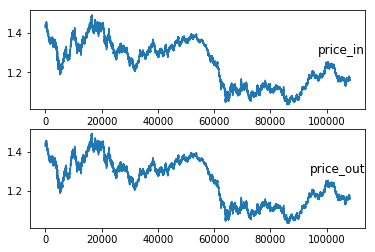

In [6]:
# Visualiza con Matplotlib
# Visualiza 
val = dfapp.values
plt.figure()
for col in range(len(dfapp.columns)):
	plt.subplot(len(dfapp.columns), 1, col+1)
	plt.plot(val[:, col])
	plt.title(dfapp.columns[col], y=0.5, loc='right')
plt.show()

In [7]:
# Creo los scalers de cada columna (entradas y salidas)
values = dfapp.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)

# actualizo el dataframe
df_scaled = pd.DataFrame(data=values, columns=dfapp.columns)
df_scaled.head()

,price_in,price_out
0,0.734239,0.734239
1,0.730525,0.730525
2,0.729650,0.729650
3,0.718855,0.718855
4,0.714922,0.714922


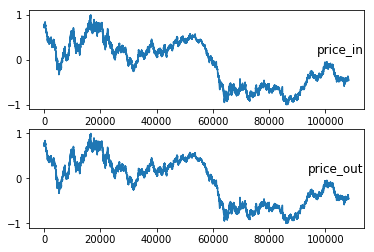

In [8]:
# Visualiza muestras en Matplotlib
plt.figure()
for col in range(len(dfapp.columns)):
	plt.subplot(len(dfapp.columns), 1, col+1)
	plt.plot(values[:, col])
	plt.title(dfapp.columns[col], y=0.5, loc='right')

In [9]:
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df_in.shift(i))
    names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

# Creo columnas para las 48 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 48
num_out_steps = 4
sts_df = series_to_supervised(df_scaled, num_inputs, num_outputs, num_in_steps, num_out_steps)
sts_values = sts_df.values
print('Número de muestras total: ', sts_df.shape[0])
sts_df.head()

Número de muestras total:  108224


,price_in(t-48),price_in(t-47),price_in(t-46),price_in(t-45),price_in(t-44),price_in(t-43),price_in(t-42),price_in(t-41),price_in(t-40),price_in(t-39),...,price_in(t-6),price_in(t-5),price_in(t-4),price_in(t-3),price_in(t-2),price_in(t-1),price_out(t),price_out(t+1),price_out(t+2),price_out(t+3)
48,0.734239,0.730525,0.729650,0.718855,0.714922,0.710945,0.714485,0.721172,0.715621,0.717195,...,0.775801,0.772173,0.771169,0.772698,0.774053,0.772392,0.774665,0.778030,0.778423,0.775539
49,0.730525,0.729650,0.718855,0.714922,0.710945,0.714485,0.721172,0.715621,0.717195,0.719773,...,0.772173,0.771169,0.772698,0.774053,0.772392,0.774665,0.778030,0.778423,0.775539,0.775496
50,0.729650,0.718855,0.714922,0.710945,0.714485,0.721172,0.715621,0.717195,0.719773,0.719337,...,0.771169,0.772698,0.774053,0.772392,0.774665,0.778030,0.778423,0.775539,0.775496,0.775801
51,0.718855,0.714922,0.710945,0.714485,0.721172,0.715621,0.717195,0.719773,0.719337,0.723138,...,0.772698,0.774053,0.772392,0.774665,0.778030,0.778423,0.775539,0.775496,0.775801,0.773354
52,0.714922,0.710945,0.714485,0.721172,0.715621,0.717195,0.719773,0.719337,0.723138,0.724013,...,0.774053,0.772392,0.774665,0.778030,0.778423,0.775539,0.775496,0.775801,0.773354,0.773747


In [10]:
print('Values shape: ', sts_values.shape, '\r\n')
num_train_samples = int(sts_df.shape[0] * 0.6)
num_test_samples = int(sts_df.shape[0] * 0.2)
num_validation_samples = sts_df.shape[0] - num_train_samples - num_test_samples

# obtengo los conjuntos train-test-validation
train = sts_values[0:num_train_samples,:]
test = sts_values[num_train_samples:num_train_samples+num_test_samples,:]
validation = sts_values[num_train_samples+num_test_samples:num_train_samples+num_test_samples+num_validation_samples,:]
print('Train shape:', train.shape, ' Test shape:', test.shape, 'Validation shape:', validation.shape, '\r\n')

# obtengo los pares x-y de cada conjunto
x_train, y_train = train[:,:-num_out_steps], train[:,-num_out_steps:]
x_test, y_test = test[:,:-num_out_steps], test[:,-num_out_steps:]
x_validation, y_validation = validation[:,:-num_out_steps], validation[:,-num_out_steps:]
print('X Train shape:', x_train.shape, ' Y Train shape:', y_train.shape, '\r\n')
print('X Test shape:', x_test.shape, ' Y Test shape:', y_test.shape, '\r\n')
print('X Validation shape:', x_validation.shape, ' Y Validation shape:', y_validation.shape, '\r\n')

# acondiciono los formatos a la entrada LSTM (num_samples, num_steps, num_features)
x_train = x_train.reshape((x_train.shape[0], num_in_steps, num_inputs))
x_test = x_test.reshape((x_test.shape[0], num_in_steps, num_inputs))
x_validation = x_validation.reshape((x_validation.shape[0], num_in_steps, num_inputs))

print('X Train reshape:', x_train.shape, ' Y Train reshape:', y_train.shape, '\r\n')
print('X Test reshape:', x_test.shape, ' Y Test reshape:', y_test.shape, '\r\n')
print('X Validation reshape:', x_validation.shape, ' Y Validation reshape:', y_validation.shape, '\r\n')


Values shape:  (108224, 52) 

Train shape: (64934, 52)  Test shape: (21644, 52) Validation shape: (21646, 52) 

X Train shape: (64934, 48)  Y Train shape: (64934, 4) 

X Test shape: (21644, 48)  Y Test shape: (21644, 4) 

X Validation shape: (21646, 48)  Y Validation shape: (21646, 4) 

X Train reshape: (64934, 48, 1)  Y Train reshape: (64934, 4) 

X Test reshape: (21644, 48, 1)  Y Test reshape: (21644, 4) 

X Validation reshape: (21646, 48, 1)  Y Validation reshape: (21646, 4) 



In [11]:
# callback para hacer backup de los pesos en el ordenador local
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self):
    pass
  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  '''
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  def on_epoch_end(self, epoch, logs={}):
    print('... eopch Finished!')
    return
  
  

In [12]:
file_weights = "model_weights_univariate.hdf5"

In [13]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

# Crea un modelo LSTM simple de dos capas ocultas
def build_vanilla_lstm(num_cells, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  # la primera capa cuenta con un número de neuronas 'num_cells' y activa el flag 'return_sequences' para que su
  # salida pueda encadenarse a otra capa LSTM, es decir tenga el formato (num_samples, num_steps, num_features)
  # añado una capa de Dropout para eliminar overfitting
  model.add(LSTM(num_cells, return_sequences=True, input_shape=(num_in_steps, num_inputs)))
  model.add(BatchNormalization())
  model.add(Dropout(0.20))

  # la segunda capa cuenta con un número de neuronas 'num_cells' y activa el flag 'return_sequences' para que su
  # salida pueda encadenarse a otra capa LSTM, es decir tenga el formato (num_samples, num_steps, num_features)
  # añado una capa de Dropout para eliminar overfitting
  model.add(LSTM(num_cells, return_sequences=True))
  model.add(BatchNormalization())
  model.add(Dropout(0.20))

  # la tercera capa es otra capa LSTM con el mismo número de células, pero ya no es necesario especificar el formato de entrada
  model.add(LSTM(num_cells))
  model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  # la capa intermedia Dense, que procesa los features extraidos de las capas lstm
  #model.add(Dense(num_cells, activation='sigmoid', kernel_initializer='normal', kernel_constraint=max_norm(3)))
  #model.add(BatchNormalization())
  #model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  #optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
  #model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])  
  model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  download_weights = DownloadWeights(filepath)
  fitlogger = FitLogger()
  # callback para visualización en tensorboard
  tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)
  callbacks_list = [checkpoint]
  #callbacks_list = [checkpoint, tbCallBack, fitlogger] #, checkpoint, download_weights]

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

num_cells = 128
batch_size = 32
model, callbacks_list = build_vanilla_lstm(num_cells, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)

No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 128)           66560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 128)           131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)            

In [14]:
# hago un control de epochs manual
epoch_count = 0
loss, val_loss = np.ndarray((0,)), np.ndarray((0,))

def save_weights(model, filename):
  # Serialización del modelo en formato json
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
      json_file.write(model_json)

  # Serializa los pesos a formato HDF5
  model.save_weights(filename)
  print("Saved model to disk")


In [15]:
# Inicia el entrenamiento y validación con los pares de entrenamiento
# para evitar perder los pesos en cierres esporádicos de la conexión del notebook, hago un backup en cada epoch
# de forma manual.
num_epochs = 500
  
print('Iniciando entrenamiento en epoch=',epoch_count)
try:
  history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(x_test,y_test), verbose=2, shuffle=True) 
  # guardo pesos del epoch actual
  save_weights(model, 'model.h5') 

  loss = np.append(loss, np.asarray(history.history['loss']), axis=0)
  val_loss = np.append(val_loss, np.asarray(history.history['val_loss']), axis=0)
  plt.plot(loss[:])
  plt.plot(val_loss[:])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()
  epoch_count += num_epochs

  # Evalúa el funcionamiento con la partición de evaluación
  scores = model.evaluate(x_validation, y_validation, verbose=2)
  print("Model Accuracy: %.2f%%" % (scores[1]*100))
    
except:
  print('Model fit Exception:', sys.exc_info()[0])

  


Iniciando entrenamiento en epoch= 0
Train on 64934 samples, validate on 21644 samples
Epoch 1/500
 - 599s - loss: 0.0886 - acc: 0.2508 - val_loss: 0.0176 - val_acc: 0.1952
Epoch 2/500
 - 534s - loss: 0.0054 - acc: 0.2575 - val_loss: 0.0071 - val_acc: 0.2133
Epoch 3/500
 - 570s - loss: 0.0048 - acc: 0.2622 - val_loss: 0.0140 - val_acc: 0.1945
Epoch 4/500
 - 549s - loss: 0.0047 - acc: 0.2594 - val_loss: 0.0032 - val_acc: 0.2978
Epoch 5/500
 - 542s - loss: 0.0047 - acc: 0.2631 - val_loss: 0.0097 - val_acc: 0.2978
Epoch 6/500
 - 541s - loss: 0.0046 - acc: 0.2608 - val_loss: 0.0238 - val_acc: 0.1952
Epoch 7/500
 - 546s - loss: 0.0043 - acc: 0.2627 - val_loss: 0.0025 - val_acc: 0.2978
Epoch 8/500
 - 542s - loss: 0.0044 - acc: 0.2624 - val_loss: 0.0028 - val_acc: 0.2786
Epoch 9/500
 - 550s - loss: 0.0045 - acc: 0.2637 - val_loss: 0.0035 - val_acc: 0.2978
Epoch 10/500
 - 576s - loss: 0.0044 - acc: 0.2661 - val_loss: 0.0203 - val_acc: 0.3114
Epoch 11/500
 - 539s - loss: 0.0042 - acc: 0.2643 - v

Epoch 94/500
 - 511s - loss: 0.0038 - acc: 0.2633 - val_loss: 0.0030 - val_acc: 0.1950
Epoch 95/500
 - 520s - loss: 0.0039 - acc: 0.2627 - val_loss: 2.2619e-04 - val_acc: 0.1952
Epoch 96/500
 - 514s - loss: 0.0037 - acc: 0.2593 - val_loss: 7.1762e-04 - val_acc: 0.3127
Epoch 97/500
 - 515s - loss: 0.0038 - acc: 0.2622 - val_loss: 0.0024 - val_acc: 0.2371
Epoch 98/500
 - 514s - loss: 0.0037 - acc: 0.2647 - val_loss: 1.9540e-04 - val_acc: 0.3127
Epoch 99/500
 - 513s - loss: 0.0038 - acc: 0.2662 - val_loss: 7.9987e-04 - val_acc: 0.1942
Epoch 100/500
 - 512s - loss: 0.0037 - acc: 0.2677 - val_loss: 0.0017 - val_acc: 0.2978
Epoch 101/500
 - 513s - loss: 0.0036 - acc: 0.2649 - val_loss: 0.0021 - val_acc: 0.2978
Epoch 102/500
 - 515s - loss: 0.0036 - acc: 0.2604 - val_loss: 2.4964e-04 - val_acc: 0.3127
Epoch 103/500
 - 515s - loss: 0.0036 - acc: 0.2650 - val_loss: 0.0014 - val_acc: 0.3127
Epoch 104/500
 - 512s - loss: 0.0037 - acc: 0.2632 - val_loss: 2.5339e-04 - val_acc: 0.1952
Epoch 105/500


In [16]:
# Evalúa el funcionamiento con la partición de evaluación
  scores = model.evaluate(x_validation, y_validation, verbose=2)
  print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Accuracy: 30.68%


In [17]:
# Pruebas de visualización de resultados. Preparación de datos
sample = 0
x_data = x_test
y_data = y_test 


RMSE: 0.013841


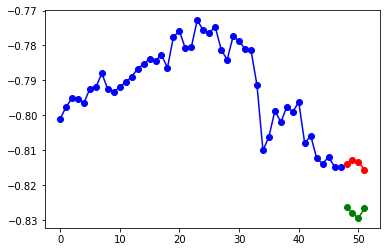

In [18]:
import math
# Visualización de muestra 'sample'
plt.plot(x_data[sample], marker='o', color='b')
# Visualizo salida esperada
p = np.arange(num_in_steps, num_in_steps+num_out_steps)
plt.plot(p, y_data[sample], marker='o', color='r')
# Realizo predicción del primer conjunto de datos
x = x_data[sample].reshape(1, num_in_steps, 1)
y = y_data[sample].reshape(1,num_out_steps)
predictions = model.predict(x, batch_size=1,verbose=0)
# Visualizo predicción
plt.plot(p, predictions[0], marker='o', color='g')
# Calculo el error RMSE
rmse = math.sqrt(sk.mean_squared_error(y_data[sample], predictions[0], multioutput = 'uniform_average'))
print('RMSE: %f' % rmse)

sample += 1

Text(0.5, 1.0, 'EURUSD OHLC en M30')

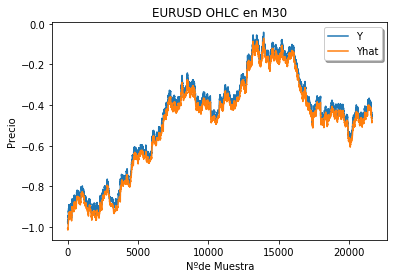

In [19]:
# Una vez validado, realiza las predicciones con las entradas de validación, visualiza y obtiene error
x_eval = x_validation
y_eval = y_validation
yhat = np.ndarray(shape=y_eval.shape)
y = np.ndarray(shape=y_eval.shape)
for i in range(x_eval.shape[0]):
  x = x_eval[i]
  x = x.reshape(1, num_in_steps, num_inputs)
  y[i] = y_eval[i]
  predictions = model.predict(x, batch_size=1, verbose=0)
  yhat[i] = predictions

# creo array de resultados, deshago inversión  
yresult = np.ndarray(shape=y.shape)
yresult[:,0] = y[:,0]
yresult[:,1] = yhat[:,0]
#yresult = scaler.inverse_transform(yresult)
 
# visualizo los resultados
plt.plot(yresult[:,0])
plt.plot(yresult[:,1])
#plt.plot(y[:,0])
#plt.plot(yhat[:,0])
plt.xlabel('Nºde Muestra')
plt.ylabel('Precio')
plt.legend(('Y','Yhat'), loc='upper right', shadow=True)
plt.title('EURUSD OHLC en M30') 
    


In [ ]:
plt.plot(yresult[:7000,0])
plt.plot(yresult[:7000,1])